# Example from page 329 VMLS book

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [2]:
# Generating signals
c = 1.54
alpha = np.array([0.66, -0.90, -0.66, .89])
w = np.array([13.69, 3.55, 23.25, 6.03])
phi = np.array([0.21, 0.02, -1.87, 1.72])

def s(x, c, alpha, w, phi):
    K = len(alpha)
    return c + np.sum([alpha[k] * np.sin(w[k] * x + phi[k]) for k in range(K)], axis=0)

n_train, n_test = 40, 40
x_train = np.random.rand(n_train)
y_train = s(x_train, c, alpha, w, phi) + 0.1*np.random.randn(n_train)
x_test = np.random.rand(n_test)
y_test = s(x_test, c, alpha, w, phi) + 0.1*np.random.randn(n_test)
x_plot = np.linspace(0, 1, 100)
y_plot = s(x_plot, c, alpha, w, phi)

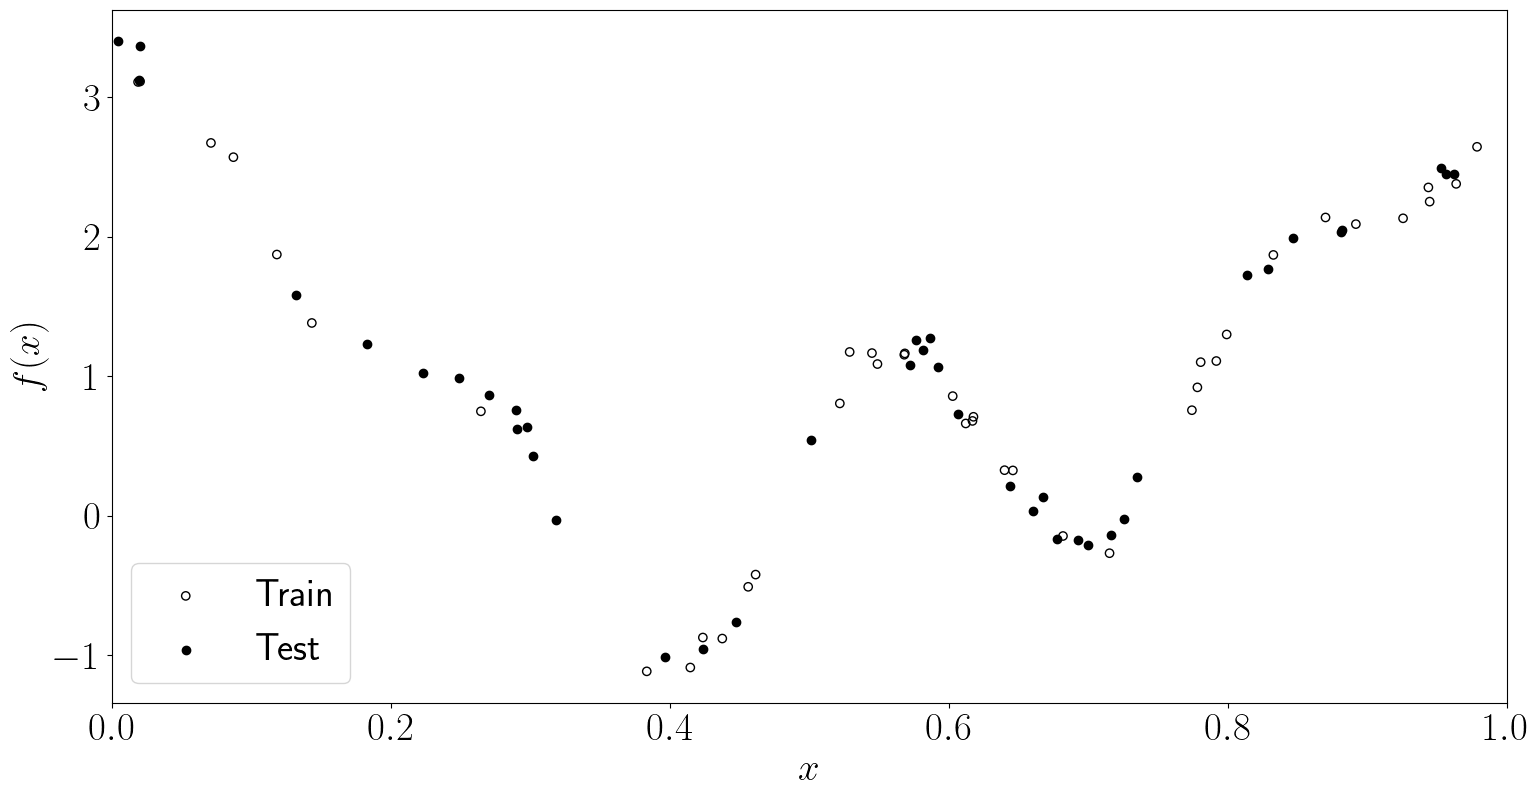

In [3]:
# Plot signals
# plot solution versus lambda
fig, ax = plt.subplots(1,1, figsize=(18, 9))
ax.scatter(x_train, y_train, marker='o', color='k', facecolors='none', label="Train")
ax.scatter(x_test, y_test, marker='o', color='k', facecolors='k', label="Test")
ax.legend()
# ax.plot(x_plot, y_plot)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim([0, 1]) 
plt.savefig('regularized_fitting_points.pdf')

In [5]:
# Fit a model with 5 parameters
p = 5 # Model parameters

# Define lstsq problem
A = np.column_stack([np.ones(n_train), np.sin(np.outer(x_train, w) + np.outer(np.ones(n_train), phi))])
A_test = np.column_stack([np.ones(n_test), np.sin(np.outer(x_test, w) + np.outer(np.ones(n_test), phi))])
As = [A, np.column_stack([np.zeros(p-1), np.eye(p-1)])]
bs = [y_train, np.zeros(p-1)]

# Train for different lambdas
n_lambdas = 100
lambdas = np.logspace(-6, 6, n_lambdas)
error_train = np.zeros(n_lambdas)
error_test = np.zeros(n_lambdas)
thetas = np.zeros((p, n_lambdas))


# Define optimization problem
lam = cp.Parameter(nonneg=True)
theta = cp.Variable(p)
objective = cp.norm(A @ theta - y_train, 1) + lam * cp.norm(theta, 1)
problem = cp.Problem(cp.Minimize(objective), [])


for k in range(n_lambdas):
    lam.value = lambdas[k]
    problem.solve()
    theta_val = theta.value
    error_train[k] = np.sqrt(np.sum(np.square(A @ theta_val - y_train))/n_train)
    error_test[k] = np.sqrt(np.sum(np.square(A_test @ theta_val - y_test))/n_test)
    thetas[:, k] = theta_val

# Compute best lambda
lam_best = lambdas[np.argmin(error_test)]

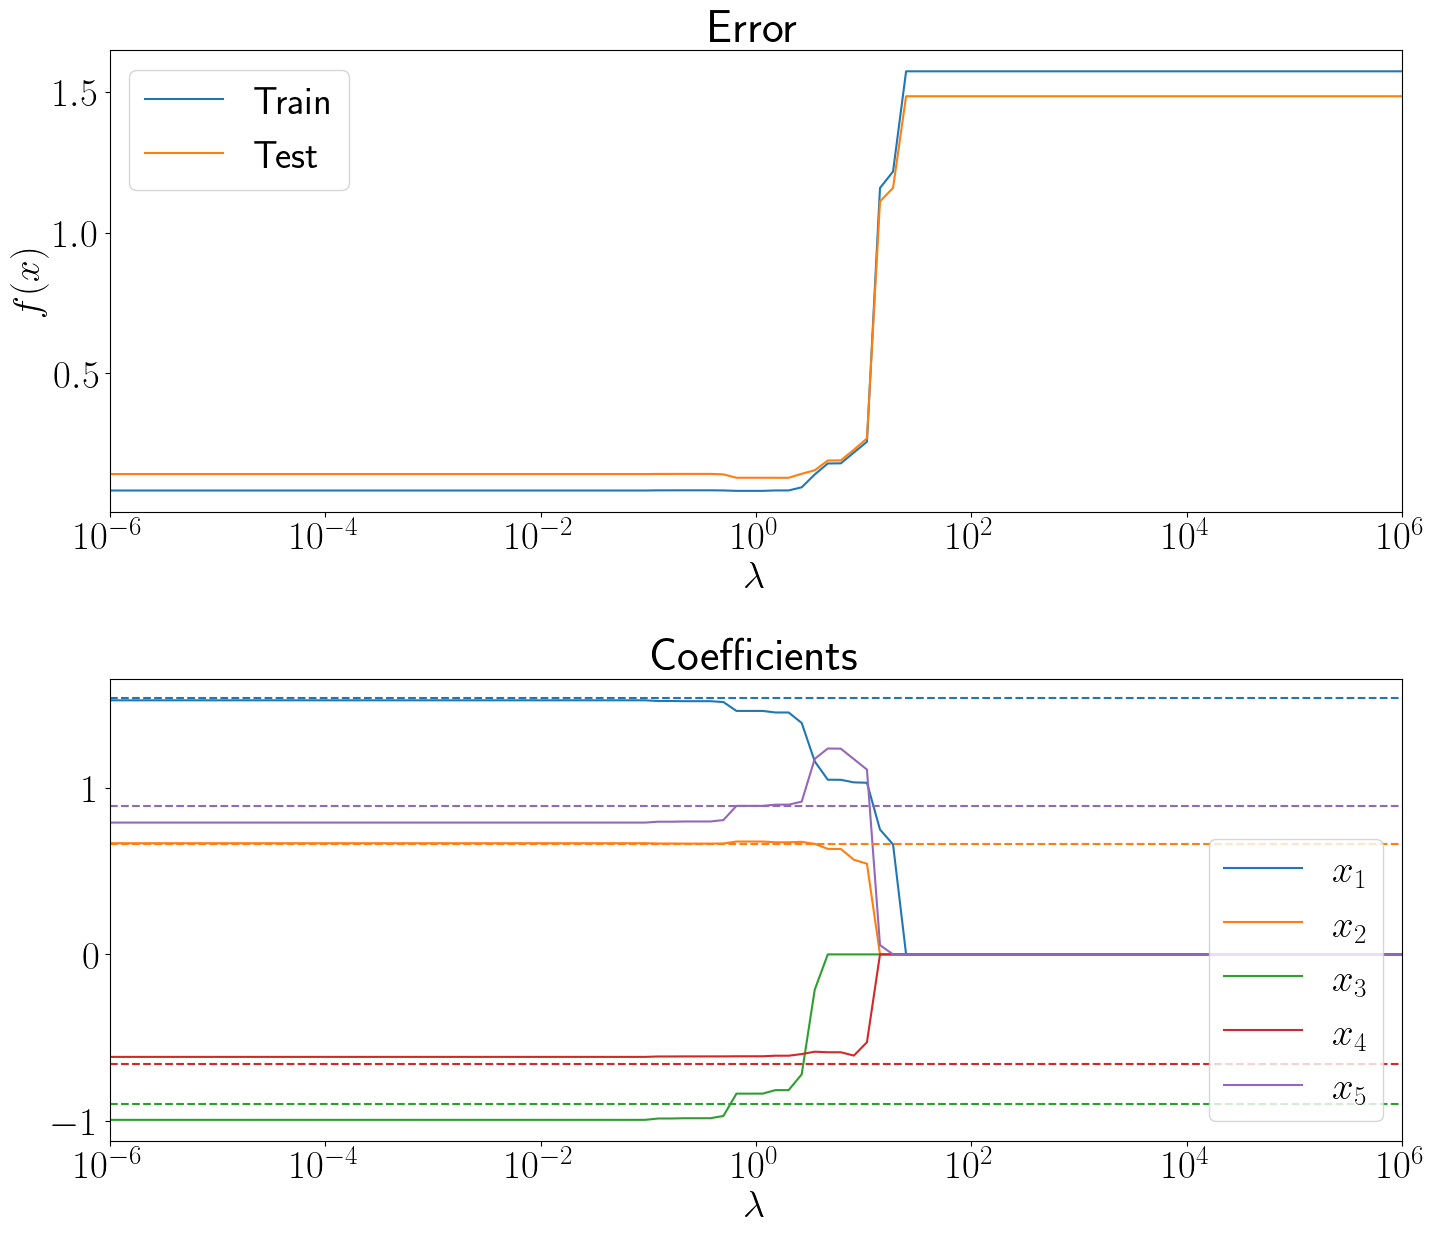

In [6]:
fig, ax = plt.subplots(2,1, figsize=(15, 13))

# Plot train vs test error
ax[0].plot(lambdas, error_train, label="Train")
ax[0].plot(lambdas, error_test, label="Test")
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$f(x)$')
ax[0].set_title('Error')
ax[0].set_xlim([lambdas[0], lambdas[-1]])

# Plot coefficients
ax[1].plot(lambdas, thetas.T)
ax[1].legend([r"$x_{%d}$" % (k+1) for k in range(p)], loc='lower right')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax[1].axhline(y=c, color=colors[0], linestyle='--') 
for k in range(1, 5):
    ax[1].axhline(y=alpha[k-1], color=colors[k], linestyle='--') 

ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_title('Coefficients')
ax[1].set_xlim([lambdas[0], lambdas[-1]])

plt.tight_layout()
plt.savefig("regularized_fitting_path.pdf")

In [7]:
lam_best

1.5199110829529332